In [1]:
import doctest
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
processed_otter = pd.read_csv("processed_data/otters_processed.csv")
processed_urchin = pd.read_csv("processed_data/urchins_processed.csv")
processed_shark = pd.read_csv("processed_data/sharks_processed.csv")
processed_kelp = pd.read_csv("processed_data/kelp_processed.csv")
processed_hotdays = pd.read_csv("processed_data/hotdays_processed.csv")

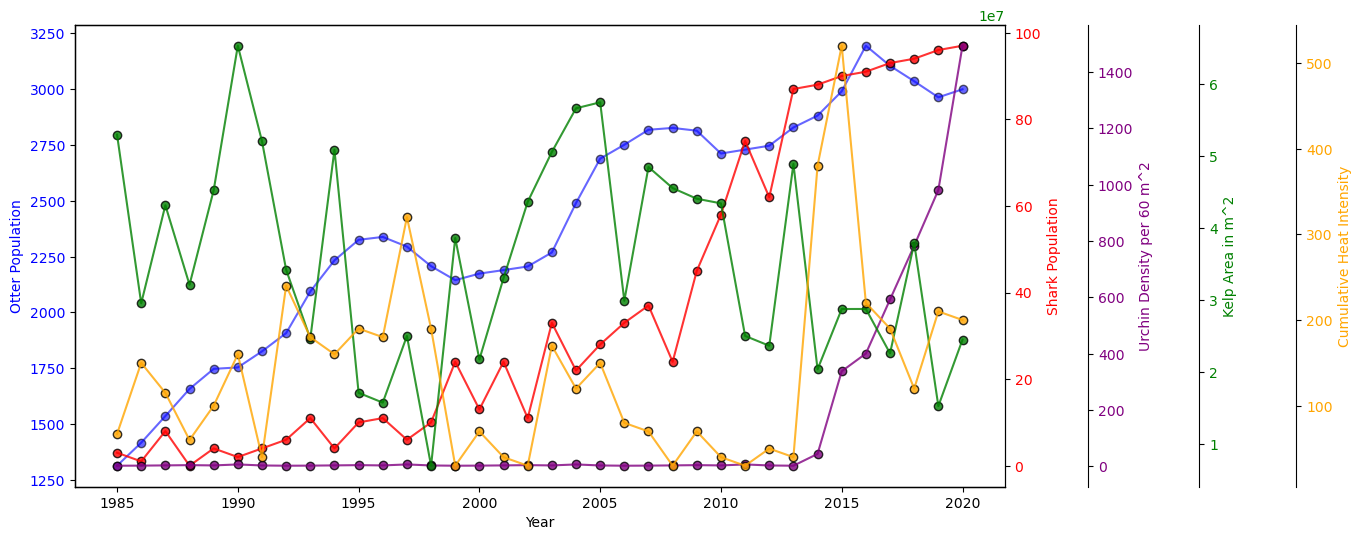

In [268]:
# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Otter Population
ax1.scatter(processed_otter["Year"], processed_otter["Total_Pop"], color="blue", alpha=0.6, edgecolors="black", label="Otter Population")
ax1.plot(processed_otter["Year"], processed_otter["Total_Pop"], color="blue", alpha=0.6)  # Connect points
ax1.set_xlabel("Year")
ax1.set_ylabel("Otter Population", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Shark Population
ax2 = ax1.twinx()
ax2.scatter(processed_shark["Year"], processed_shark["Total_Pop"], color="red", alpha=0.8, edgecolors="black", label="Shark Population")
ax2.plot(processed_shark["Year"], processed_shark["Total_Pop"], color="red", alpha=0.8)  # Connect points
ax2.set_ylabel("Shark Population", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Urchin Density
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.scatter(processed_urchin["Year"], processed_urchin["Avg_Density"], color="purple", alpha=0.8, edgecolors="black", label="Urchin Density")
ax3.plot(processed_urchin["Year"], processed_urchin["Avg_Density"], color="purple", alpha=0.8)  # Connect points
ax3.set_ylabel("Urchin Density per 60 m^2", color="purple")
ax3.tick_params(axis="y", labelcolor="purple")

# Kelp Area
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 140))
ax4.scatter(processed_kelp["Year"], processed_kelp["Total_Area"], color="green", alpha=0.8, edgecolors="black", label="Kelp Area")
ax4.plot(processed_kelp["Year"], processed_kelp["Total_Area"], color="green", alpha=0.8)  # Connect points
ax4.set_ylabel("Kelp Area in m^2", color="green")
ax4.tick_params(axis="y", labelcolor="green")

# High SST Days
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 210))
ax5.scatter(processed_hotdays["Year"], processed_hotdays["Hot_Days"], color="orange", alpha=0.8, edgecolors="black", label="High SST Days")
ax5.plot(processed_hotdays["Year"], processed_hotdays["Hot_Days"], color="orange", alpha=0.8)  # Connect points
ax5.set_ylabel("Cumulative Heat Intensity", color="orange")
ax5.tick_params(axis="y", labelcolor="orange")

# Title
 
# Show the plot
plt.show()

# Substitute Kelp/Hot Days Plot with a good fit oscillatory func

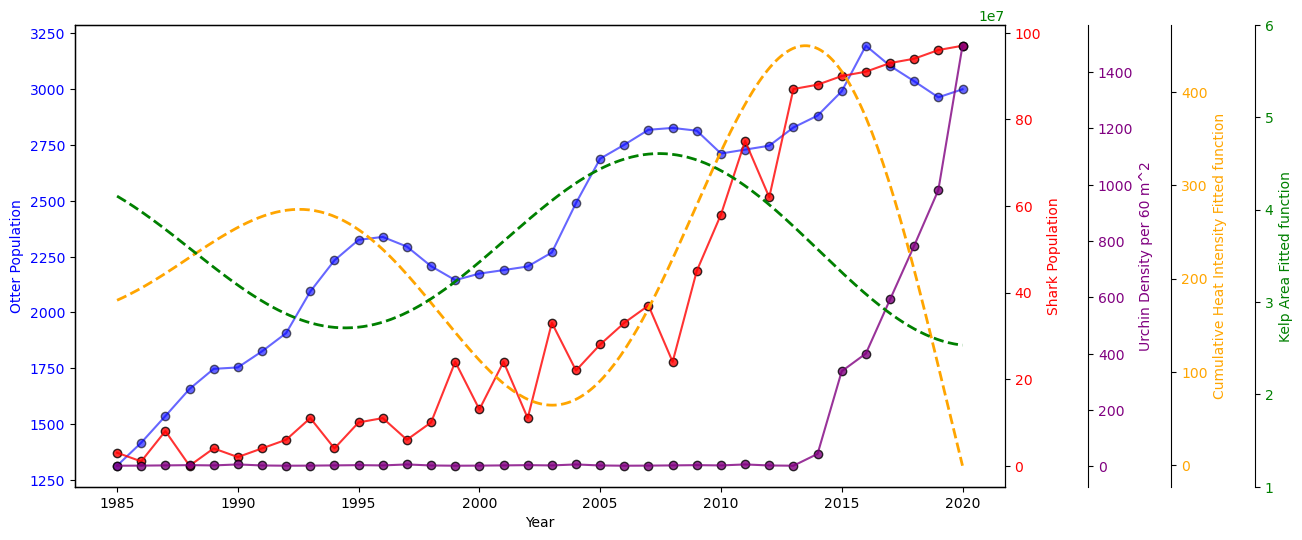

In [269]:
# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define the function
def hotdays_function(x):
    return 4.866e-49 * np.sin(0.3 * (x+3)) * np.exp(0.058 * x) + 200.1605

# Generate x values based on the range of your data
hot_x = np.linspace(min(processed_otter["Year"]), max(processed_otter["Year"]), 300)
hot_y = hotdays_function(hot_x)

# Define the function
def kelp_function(x):
    return 2.8630 * np.sin(0.2418 * x + 0.0061) * np.exp(0.0075 * x) + 36164490.4391
    #return 50000000000000 * np.sin(0.25 * x - 4.5) * np.exp(-0.015 * x) + 1310000000000.1605

# Generate x values based on the range of your data
kelp_x = np.linspace(min(processed_otter["Year"]), max(processed_otter["Year"]), 300)
kelp_y = kelp_function(kelp_x)


# Otter Population
ax1.scatter(processed_otter["Year"], processed_otter["Total_Pop"], color="blue", alpha=0.6, edgecolors="black", label="Otter Population")
ax1.plot(processed_otter["Year"], processed_otter["Total_Pop"], color="blue", alpha=0.6)  # Connect points
ax1.set_xlabel("Year")
ax1.set_ylabel("Otter Population", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Shark Population
ax2 = ax1.twinx()
ax2.scatter(processed_shark["Year"], processed_shark["Total_Pop"], color="red", alpha=0.8, edgecolors="black", label="Shark Population")
ax2.plot(processed_shark["Year"], processed_shark["Total_Pop"], color="red", alpha=0.8)  # Connect points
ax2.set_ylabel("Shark Population", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Urchin Density
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.scatter(processed_urchin["Year"], processed_urchin["Avg_Density"], color="purple", alpha=0.8, edgecolors="black", label="Urchin Density")
ax3.plot(processed_urchin["Year"], processed_urchin["Avg_Density"], color="purple", alpha=0.8)  # Connect points
ax3.set_ylabel("Urchin Density per 60 m^2", color="purple")
ax3.tick_params(axis="y", labelcolor="purple")

# Overlay function axis
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))  # Further separate this axis
ax4.plot(hot_x, hot_y, color="orange", linestyle="--", linewidth=2, label="Hot Days Estimate")
ax4.set_ylabel("Cumulative Heat Intensity Fitted function", color="orange")
ax4.tick_params(axis="y", labelcolor="orange")

# Overlay function axis
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 180))  # Further separate this axis
ax5.plot(kelp_x, kelp_y, color="green", linestyle="--", linewidth=2, label="Kelp Area Estimate")
ax5.set_ylabel("Kelp Area Fitted function", color="green")
ax5.tick_params(axis="y", labelcolor="green")
ax5.set_ylim([1e7, 6e7])


# Title
 
# Show the plot
plt.show()

# Solving for constants

# Naive ODE using constants only (no kelp, no temp)

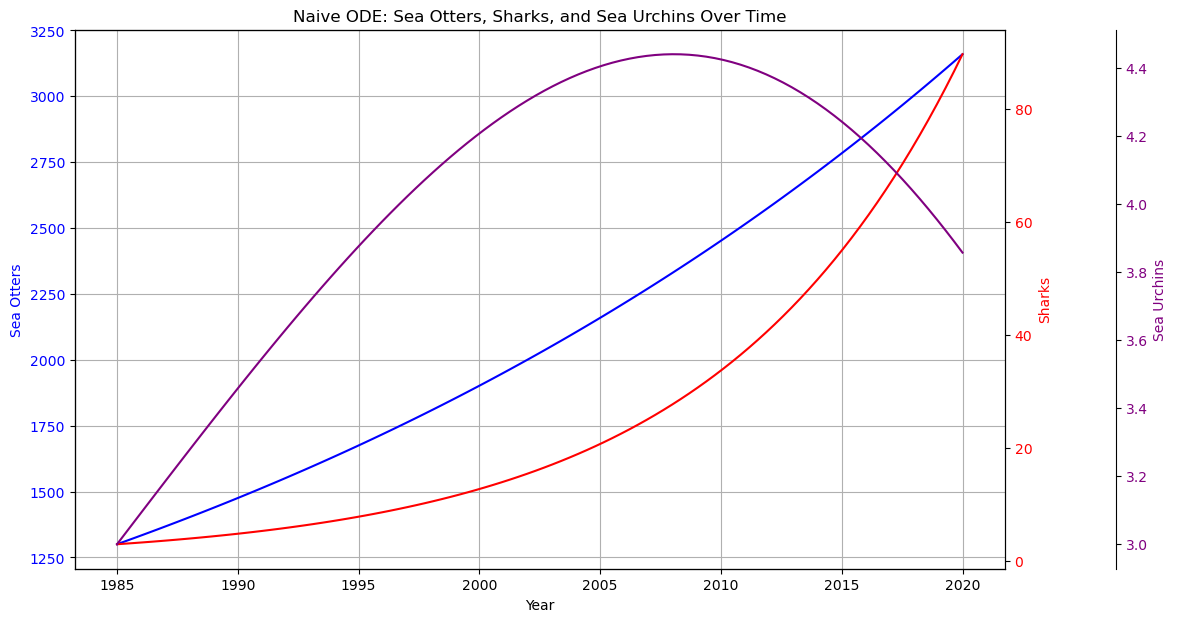

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define constant parameters
a = 0.07  
b = 0.00003

d = 0.025
e = 0.0001
f = 0.000001

g = 0.095
h = 0.000001

# Define the system of ODEs based on your equations
def system(y, t, a, b, d, e, f, g, h):
    U, R, S = y
    dU_dt = a * U - b * U * R
    dR_dt = d * R + e * U * R - f * S * R
    dS_dt = g * S + h * S * R
    return [dU_dt, dR_dt, dS_dt]

# Initial conditions: [U, R, S]
y0 = [3, 1300, 3]

# Time span
t = np.linspace(1985, 2020, 100)

# Solve the system:
solution = odeint(system, y0, t, args=(a, b, d, e, f, g, h))

# Extract the solution for each species
U = solution[:, 0]  # Sea urchins
R = solution[:, 1]  # Sea otters
S = solution[:, 2]  # Sharks

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# First y-axis (Sea otters)
ax1.plot(t, R, color="blue", label="Sea Otters")
ax1.set_ylabel("Sea Otters", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Second y-axis (Sharks)
ax2 = ax1.twinx()
ax2.plot(t, S, color="red", label="Sharks")
ax2.set_ylabel("Sharks", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Third y-axis (Sea urchins)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 80))  # Offset third axis to avoid overlap
ax3.plot(t, U, color="purple", label="Sea Urchins")
ax3.set_ylabel("Sea Urchins", color="purple")
ax3.tick_params(axis="y", labelcolor="purple")

# Title and grid
plt.title("Naive ODE: Sea Otters, Sharks, and Sea Urchins Over Time")
ax1.grid(True)
ax1.set_xlabel("Year")

# Show the plot
plt.show()


# Improved ODE With Kelp/Temperature Functions

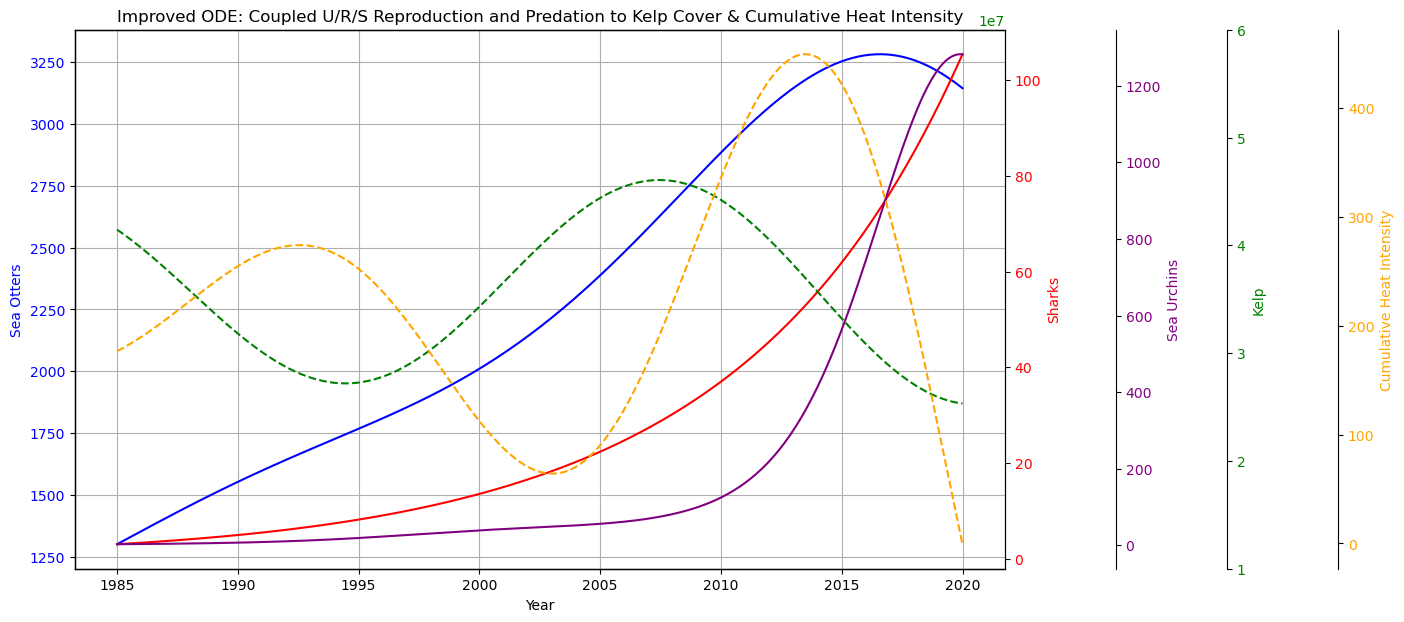

Coupled urchin reproduction to Cumulative heat intensity, coupled urchin/otter repro to Kelp cover, and coupled shark->otter predation to Kelp cover


In [271]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define constant parameters
a = 0.000000001
b = 0.00001
c = 0.0007

d = 0.000000001
e = 0.0000001
f = 12000

g = 0.095
h = 100

# Define the kelp function K(x)
def kelp_function(x):
    return 2.8630 * np.sin(0.2418 * x + 0.0061) * np.exp(0.0075 * x) + 36164490.4391

# Define the hot days function T(x)
def hotdays_function(x):
    return 4.866e-49 * np.sin(0.3 * (x + 3)) * np.exp(0.058 * x) + 200.1605

# Define the ODE system
def system(y, t, a, b, d, e, f, g, h, i, c):
    U, R, S = y
    K = kelp_function(t)
    T = hotdays_function(t)
    
    # Ensure K is never zero to avoid division errors
    K = max(K, 1e-6)
    
    # Define system equations
    dU_dt = a * K * U - b * U * R + c * T * U
    dR_dt = d * K * R + e * U * R - (f / K) * S * R
    dS_dt = g * S + (h / K) * S * R
    
    return [dU_dt, dR_dt, dS_dt]

# Initial conditions: [U, R, S]
y0 = [3, 1300, 3]

# Time span
t = np.linspace(1985, 2020, 300)

# Solve the system:
solution = odeint(system, y0, t, args=(a, b, d, e, f, g, h, i, c), mxstep=10000)

# Extract the solution for each species
U = solution[:, 0]  # Sea urchins
R = solution[:, 1]  # Sea otters
S = solution[:, 2]  # Sharks

# Generate kelp and hotdays values over time
kelp_y = kelp_function(t)
hotdays_y = hotdays_function(t)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# First y-axis (Sea otters)
ax1.plot(t, R, color="blue", label="Sea Otters")
ax1.set_ylabel("Sea Otters", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Second y-axis (Sharks)
ax2 = ax1.twinx()
ax2.plot(t, S, color="red", label="Sharks")
ax2.set_ylabel("Sharks", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Third y-axis (Sea urchins)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 80))
ax3.plot(t, U, color="purple", label="Sea Urchins")
ax3.set_ylabel("Sea Urchins", color="purple")
ax3.tick_params(axis="y", labelcolor="purple")

# Fourth y-axis (Kelp)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 160))
ax4.plot(t, kelp_y, color="green", linestyle="--", label="Kelp")
ax4.set_ylabel("Kelp", color="green")
ax4.tick_params(axis="y", labelcolor="green")
ax4.set_ylim([1e7, 6e7])

# Fifth y-axis (Hot days)
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 240))
ax5.plot(t, hotdays_y, color="orange", linestyle="--", label="Hot Days")
ax5.set_ylabel("Cumulative Heat Intensity", color="orange")
ax5.tick_params(axis="y", labelcolor="orange")

# Title and grid
plt.title("Improved ODE: Coupled U/R/S Reproduction and Predation to Kelp Cover & Cumulative Heat Intensity")
ax1.grid(True)
ax1.set_xlabel("Year")

# Show the plot
plt.show()
print("Coupled urchin reproduction to Cumulative heat intensity, coupled urchin/otter repro to Kelp cover, and coupled shark->otter predation to Kelp cover")